In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importações do TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical # Ainda útil se você quiser converter para one-hot, mas flow_from_directory pode fazer isso
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Importações concluídas!")

Importações concluídas!


In [8]:
# Caminho raiz onde foi extraído o dataset
dataset_base_dir = './data' 

train_dir = f'{dataset_base_dir}/train'
val_dir = f'{dataset_base_dir}/val'
test_dir = f'{dataset_base_dir}/test'

# Parâmetros das imagens
IMG_HEIGHT = 150 # Altura da imagem para redimensionamento
IMG_WIDTH = 150  # Largura da imagem para redimensionamento
BATCH_SIZE = 32  # Tamanho do lote para treinamento
NUM_CLASSES = 2  # NORMAL e PNEUMONIA

print(f"Caminhos do dataset configurados: \nTreino: {train_dir}\nValidação: {val_dir}\nTeste: {test_dir}")
print(f"Dimensões das imagens para a CNN: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Tamanho do lote: {BATCH_SIZE}")
print(f"Número de classes: {NUM_CLASSES}")

Caminhos do dataset configurados: 
Treino: ./data/train
Validação: ./data/val
Teste: ./data/test
Dimensões das imagens para a CNN: 150x150
Tamanho do lote: 32
Número de classes: 2


In [9]:
# Data Augmentation para o conjunto de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza os pixels para o intervalo [0, 1]
    shear_range=0.2, # Distorção de cisalhamento
    zoom_range=0.2,  # Zoom aleatório
    horizontal_flip=True # Flip horizontal
)

# Apenas normalização para os conjuntos de validação e teste (sem aumento de dados)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Configurando geradores de dados...")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary', # Para classificação binária (Pneumonia/Normal)
    color_mode='rgb' # Raios-X são em escala de cinza, mas muitos modelos esperam 3 canais.
                      # O flow_from_directory pode converter de cinza para RGB (duplicando canais).
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False # Não embaralhar para que as previsões correspondam aos rótulos
)

# Mapeamento de classes (0 ou 1 para os nomes das pastas)
# Isso é útil para entender qual número corresponde a 'NORMAL' e 'PNEUMONIA'
class_indices = train_generator.class_indices
print(f"\nMapeamento de classes: {class_indices}")

# O shape das imagens de entrada da CNN será (IMG_HEIGHT, IMG_WIDTH, 3) se color_mode='rgb'
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) if train_generator.color_mode == 'rgb' else (IMG_HEIGHT, IMG_WIDTH, 1)
print(f"Shape de entrada para a CNN será: {input_shape}")

Configurando geradores de dados...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Mapeamento de classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Shape de entrada para a CNN será: (150, 150, 3)


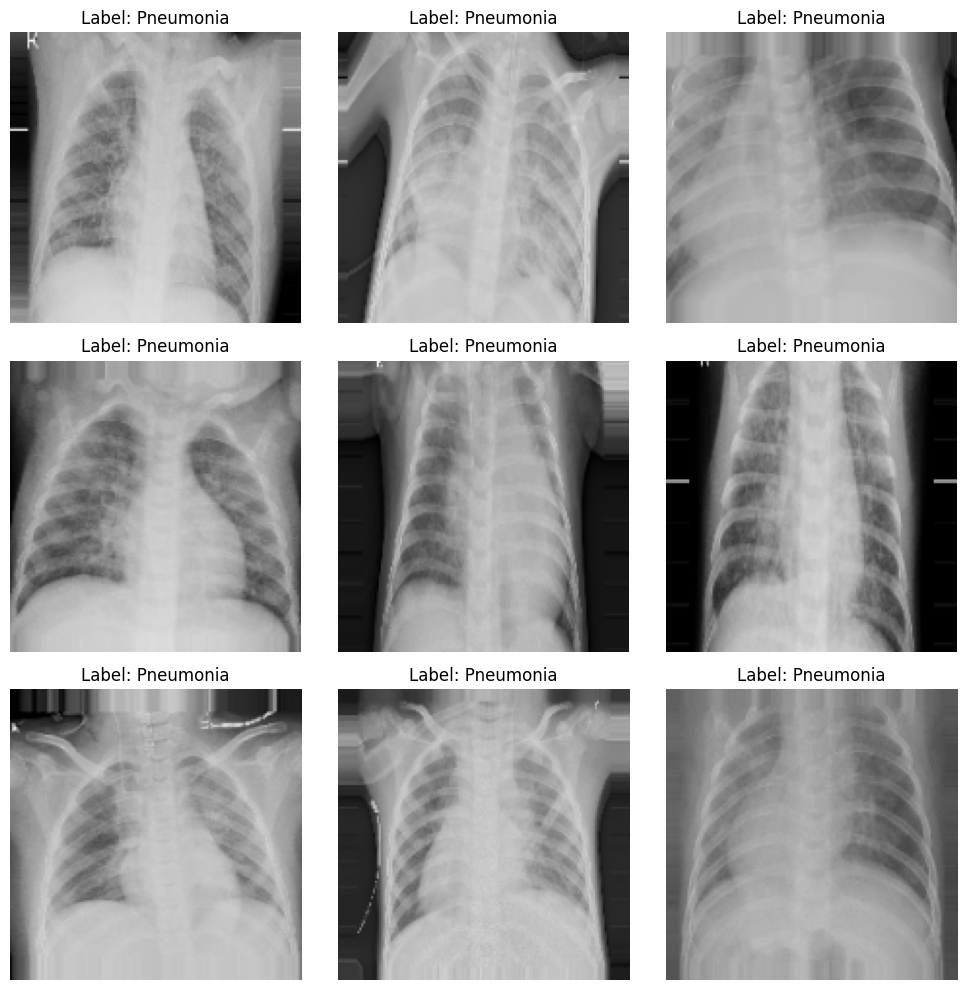

Visualização de amostras aumentadas concluída.


In [10]:
# Pega um lote de imagens aumentadas
sample_batch = next(train_generator)
images, labels = sample_batch[0], sample_batch[1]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))): # Exibir até 9 imagens do lote
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]) # Imagens já normalizadas e em RGB
    label = "Pneumonia" if labels[i] == 1 else "Normal"
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Visualização de amostras aumentadas concluída.")

In [5]:
model = Sequential()

# Bloco Convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloco Convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloco Convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Bloco Convolucional 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

# Achata a saída das camadas convolucionais para um vetor 1D
model.add(Flatten())

# Camadas Densas
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Camada de Saída para Classificação BINÁRIA
model.add(Dense(1, activation='sigmoid'))

model.summary()

d:\Documentos\Projetos\cnn-pneumonia\cnn_rexfa\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,815,937 (26.00 MB)

 Trainable params: 6,813,953 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [11]:
optimizer = Adam(learning_rate=0.001) 

loss_function = 'binary_crossentropy'
metrics = ['accuracy'] 

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
print("\nModelo compilado com sucesso!")


Modelo compilado com sucesso!


In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=0.00001)
callbacks = [early_stopping, reduce_lr]
print("Callbacks configurados.")

Callbacks configurados.


In [8]:
epochs = 50

print(f"\nIniciando o treinamento do modelo por {epochs} épocas com batch_size={BATCH_SIZE}...")
print("Isso pode levar um tempo considerável, dependendo do seu hardware (GPU é altamente recomendada).")

# steps_per_epoch e validation_steps são úteis para geradores
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks, 
    verbose=1 
)

print("\nTreinamento concluído!")


Iniciando o treinamento do modelo por 50 épocas com batch_size=32...
Isso pode levar um tempo considerável, dependendo do seu hardware (GPU é altamente recomendada).


d:\Documentos\Projetos\cnn-pneumonia\cnn_rexfa\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 984ms/step - accuracy: 0.8345 - loss: 0.4401 - val_accuracy: 0.5000 - val_loss: 30.6430 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 661ms/step - accuracy: 0.9236 - loss: 0.1912 - val_accuracy: 0.5000 - val_loss: 26.6544 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9334 - loss: 0.1876 - val_accuracy: 0.5000 - val_loss: 9.4284 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 669ms/step - accuracy: 0.9294 - loss: 0.1868 - val_accuracy: 0.5000 - val_loss: 9.4221 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 646ms/step - accuracy: 0.9375 - loss: 0.1703 - val_accuracy: 0.5000 - val_loss: 10.6801 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 656ms/step - accuracy: 0.9443 - loss: 0.1546 - val_accuracy: 0.5000 - val_loss: 4.7112 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - acc

In [9]:
print("\nAvaliando o modelo no conjunto de teste...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print(f'\nPerda no conjunto de teste (Test Loss): {test_loss:.4f}')
print(f'Acurácia no conjunto de teste (Test Accuracy): {test_acc:.4f}')


Avaliando o modelo no conjunto de teste...
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.9021 - loss: 0.2647

Perda no conjunto de teste (Test Loss): 0.2040
Acurácia no conjunto de teste (Test Accuracy): 0.9247


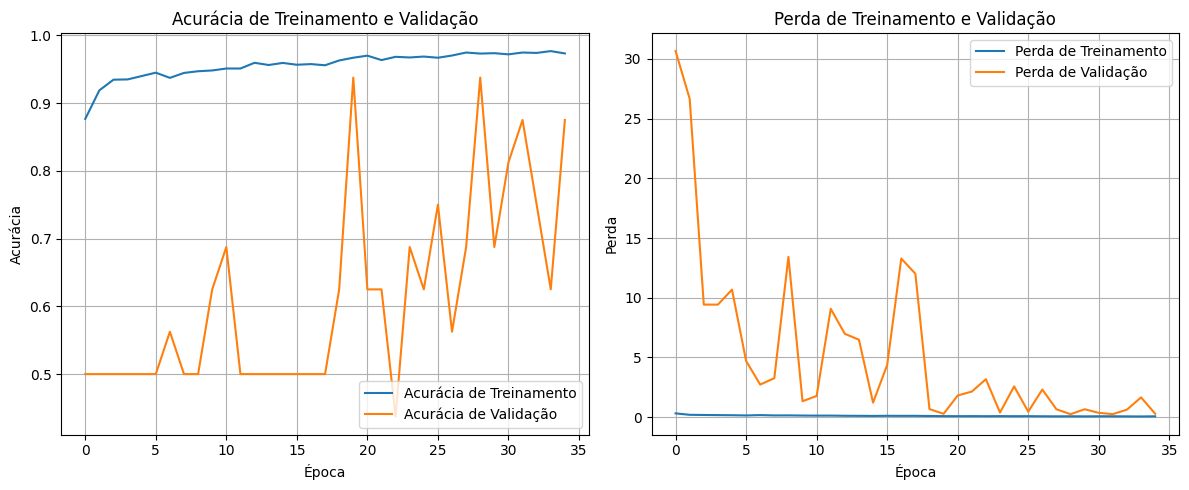

Visualização das curvas de aprendizado concluída.


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(12, 5))

# Plot da Acurácia
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.grid(True)

# Plot da Perda
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Perda de Treinamento')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.grid(True)

plt.tight_layout() 
plt.show()
print("Visualização das curvas de aprendizado concluída.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


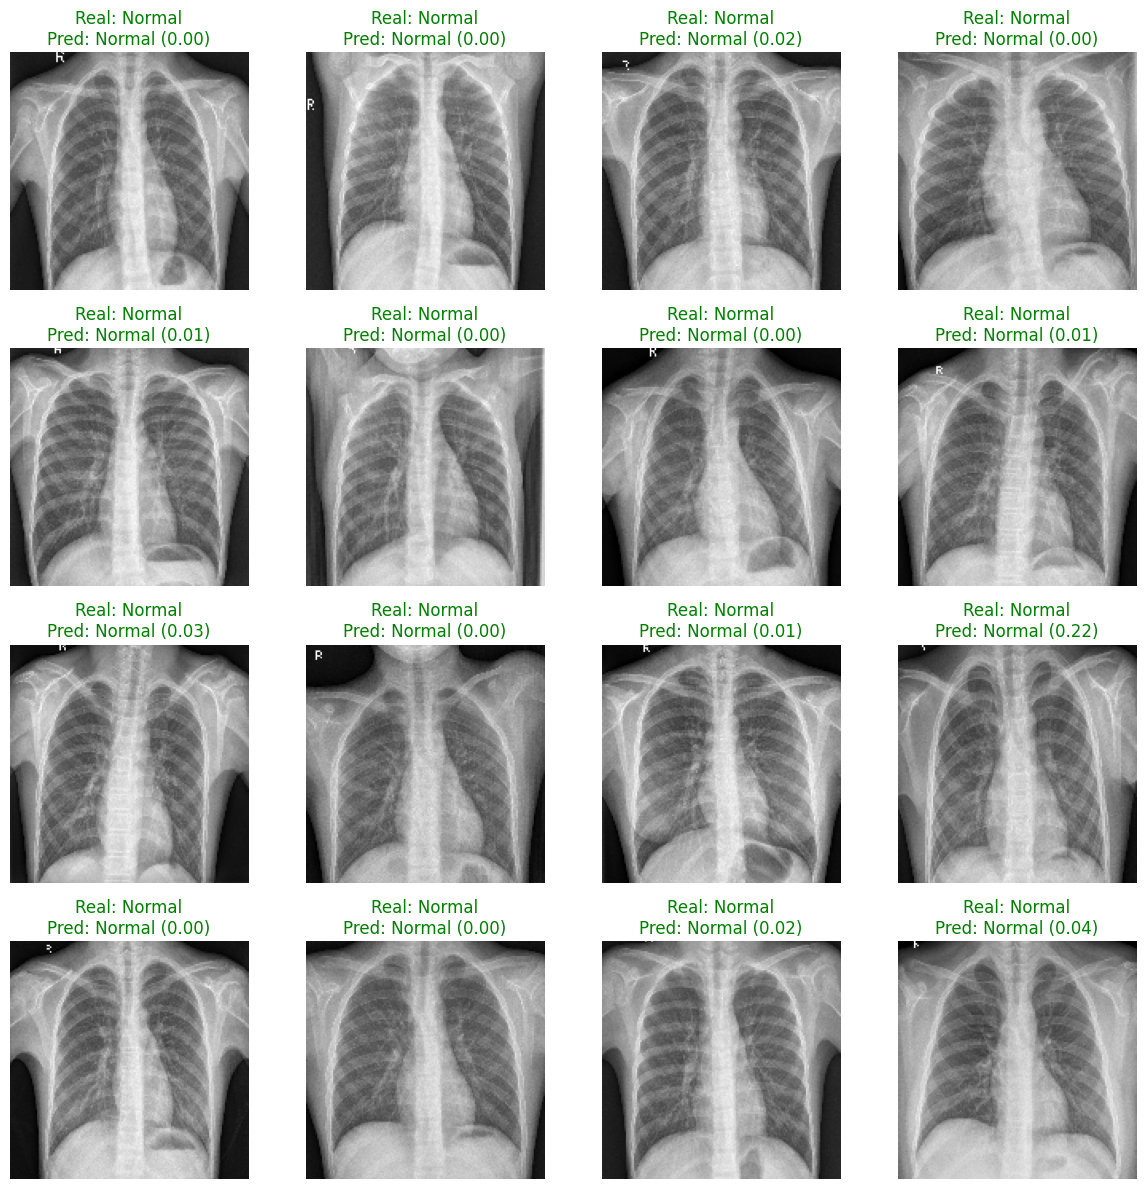

Visualização de previsões individuais concluída.


In [11]:
test_images_batch, test_labels_batch = next(test_generator)

# Fazer previsões no lote
predictions_batch = model.predict(test_images_batch)

plt.figure(figsize=(12, 12))
for i in range(min(16, len(test_images_batch))): # Exibir até 16 exemplos do lote
    plt.subplot(4, 4, i + 1)
    
    plt.imshow(test_images_batch[i]) 
    
    true_label_index = int(test_labels_batch[i]) # Rótulo real (0 ou 1)
    predicted_prob = predictions_batch[i][0] # Probabilidade de ser 1 (Pneumonia)
    
    true_label = "Pneumonia" if true_label_index == 1 else "Normal"
    predicted_label = "Pneumonia" if predicted_prob > 0.5 else "Normal" # Previsão baseada em limiar 0.5
    
    # Se a previsão estiver correta, a cor é verde; caso contrário, é vermelha
    color = 'green' if true_label_index == (1 if predicted_prob > 0.5 else 0) else 'red'
    
    plt.title(f"Real: {true_label}\nPred: {predicted_label} ({predicted_prob:.2f})", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Visualização de previsões individuais concluída.")

In [ ]:
# Para salvar o modelo treinado
model_save_path = './pneumonia_detection_model.keras' # Nome do arquivo para salvar o modelo
model.save(model_save_path)
print(f"Modelo salvo em: {model_save_path}")

In [1]:
# Carregar o Modelo Salvo (se necessário)
import os # Caso não tenha sido importado anteriormente
from tensorflow.keras.models import load_model

model_save_path = './pneumonia_detection_model.keras' # Caminho do modelo salvo

# Verificar se o arquivo do modelo existe antes de carregar
if os.path.exists(model_save_path):
    loaded_model = load_model(model_save_path)
    print(f"Modelo carregado de: {model_save_path}")
    model = loaded_model 
else:
    print(f"Aviso: O modelo '{model_save_path}' não foi encontrado. Certifique-se de que ele foi salvo anteriormente.")

Modelo carregado de: ./pneumonia_detection_model.keras


d:\Documentos\Projetos\cnn-pneumonia\cnn_env\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2 # Biblioteca popular para manipulação de imagens (instalável via 'pip install opencv-python')

# --- Exemplo 1: Usando uma imagem do conjunto de teste já pré-processada ---
# Escolha um índice de imagem do conjunto de teste (ex: a primeira imagem)
# image_index = 0 
# new_image_for_prediction = test_generator[image_index][0][0] # Pega a primeira imagem do primeiro lote do gerador de teste

# # A imagem já está no formato correto (IMG_HEIGHT, IMG_WIDTH, 3) e normalizada [0,1]
# # Mas precisamos adicionar a dimensão do lote, tornando-a (1, IMG_HEIGHT, IMG_WIDTH, 3)
# input_image_for_model = np.expand_dims(new_image_for_prediction, axis=0)

# print(f"Shape da imagem de entrada para o modelo: {input_image_for_model.shape}")

# --- Exemplo 2 (Como você faria com uma imagem do seu computador):
# new_image_path = './testes/NORMAL/NORMAL3.jpeg' 
new_image_path = './testes/PNEUMONIA/person113_bacteria_543.jpeg' 
try:
    # Carregar a imagem (cv2.imread retorna em BGR, padrão OpenCV)
    img = cv2.imread(new_image_path)
    if img is None:
        raise FileNotFoundError(f"Não foi possível carregar a imagem de {new_image_path}")
    
    # Converter para RGB se necessário (cv2.imread carrega em BGR)
    if len(img.shape) == 3 and img.shape[2] == 3: # Se já for colorido
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif len(img.shape) == 3 and img.shape[2] == 1: # Se for escala de cinza com 1 canal
        pass # Já está em grayscale
    else: # Se for grayscale sem 3 canais (cv2.imread para grayscale geralmente retorna 2D)
        img = np.expand_dims(img, axis=-1) # Adiciona dimensão do canal
        
    # Redimensionar para o tamanho de treinamento
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Se o modelo foi treinado com color_mode='rgb' (3 canais), duplique o canal cinza se a imagem for grayscale
    if input_shape[2] == 3 and img_resized.shape[2] == 1:
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Normalizar pixels
    img_normalized = img_resized.astype('float32') / 255.0
    
    # Adicionar dimensão do lote
    input_image_for_model = np.expand_dims(img_normalized, axis=0)
    
    print(f"Nova imagem carregada e preparada. Shape: {input_image_for_model.shape}")
except FileNotFoundError as e:
    print(f"ERRO: {e}")
except Exception as e:
    print(f"Ocorreu um erro ao processar a imagem: {e}")

Nova imagem carregada e preparada. Shape: (1, 150, 150, 3)


In [11]:
# Fazer a previsão (retorna a probabilidade de ser Pneumonia)
prediction_probability = model.predict(input_image_for_model)[0][0]

# Definir um limiar de 0.5 para classificar
threshold = 0.5
predicted_class = "Pneumonia" if prediction_probability > threshold else "Normal"

print(f"\nProbabilidade de Pneumonia: {prediction_probability:.4f}")
print(f"Classe Prevista: {predicted_class}")

# # Se for do test_generator, podemos comparar com o real
# true_label_index = int(test_generator[image_index][1][0])
# true_label = "Pneumonia" if true_label_index == 1 else "Normal"
# print(f"Classe Real (do dataset de teste): {true_label}")

# # Visualizar a imagem e a previsão
# plt.figure(figsize=(4, 4))
# plt.imshow(new_image_for_prediction) # Já está normalizada e color_mode correto
# plt.title(f"Real: {true_label}\nPred: {predicted_class} (Prob: {prediction_probability:.2f})")
# plt.axis('off')
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step

Probabilidade de Pneumonia: 0.9889
Classe Prevista: Pneumonia
